# Required Packages

In [0]:
!pip install networkx -q
!pip install numpy -q
!pip install pandas -q
!pip install holoviews -q
!pip install bokeh -q
!pip install scikit-image -q
!pip install xarray -q
!pip install datashader -q
!pip install IPython -q

# To use Colaboratory w/ Google Drive
!pip install -U -q PyDrive
!pip install pyvis

In [0]:
!pip install bokeh==1.2.0. -q

In [0]:
import csv, os
import networkx as nx
import numpy as np
import pandas as pd
import holoviews as hv
import seaborn as sns
from holoviews import opts 
from holoviews.operation.datashader import datashade, bundle_graph
from networkx.algorithms import community

# To use Colaboratory w/ Google Drive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials


from IPython.display import display_html
from bokeh.plotting import figure, output_file, show
from bokeh.models.renderers import GlyphRenderer
from holoviews.plotting.bokeh import BokehRenderer
#import holoviews.plotting.bokeh

import matplotlib.pyplot as plt 
from matplotlib import cm
import scipy
from sklearn.metrics import pairwise_distances

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
! ls -l

total 8
drwx------ 3 root root 4096 Oct 18 08:15 gdrive
drwxr-xr-x 1 root root 4096 Aug 27 16:17 sample_data


# Dataset

In [0]:
data_burst_by_time = np.load('/content/gdrive/My Drive/Burst_data/data_burst_by_time.npy').T
data_burst_by_time_shuffled = np.random.permutation(data_burst_by_time)
print("Averaged over channels: ", data_burst_by_time.shape)
print(data_burst_by_time.shape)

Averaged over channels:  (13092, 3410)
(13092, 3410)


In [0]:
dataset_cutted = data_burst_by_time[:,1000:2500]
dataset_cutted2 = data_burst_by_time[:,1200:2200]
print(dataset_cutted.shape)
print(dataset_cutted2.shape)

(13092, 1500)
(13092, 1000)


# KNN-Graph

In [0]:
n = data_burst_by_time.shape[0]

In [0]:
eucl_distances = pairwise_distances(data_burst_by_time,data_burst_by_time, metric = "euclidean")
sorted_eucl_dist_indices = np.argsort(eucl_distances, axis = 1)

In [0]:
def construct_knn_graph(matrix,sorted_indices,k=10, mutual = False, weighted = None):
  A = np.zeros(matrix.shape)
  if mutual: # knn graph only when among both knn connect
    for i, indices in enumerate(sorted_indices):
      if weighted == "similarity":
        k_nearest = indices[-(k+1) : -1]
      else:
        k_nearest = indices[1:k+1]    
      for j in k_nearest: 
        if i in sorted_indices[j,1:k+1]:
          if weighted:
            A[i,j] = matrix[i,j]
          else:
            A[i,j] = 1
  else:
    for i,indices in enumerate(sorted_indices): 
        if weighted == "similarity":
          k_nearest = indices[-(k+1) : -1]
          A[i,k_nearest] = matrix[i,k_nearest]
          A[k_nearest,i] = matrix[k_nearest,i]
        else:
          k_nearest = indices[1:k+1]
          if weighted=="distance":
            A[i,k_nearest] = matrix[i,k_nearest]
            A[k_nearest,i] = matrix[k_nearest,i]
          else:
            A[i,k_nearest] = 1
            A[k_nearest, i] = 1
  return A

In [0]:
A = construct_knn_graph(eucl_distances,sorted_eucl_dist_indices, k=5, mutual=False,weighted="distance")

In [0]:
A = A + 0.1/n * np.ones((n,n))

# Distance Distribution

In [0]:
def plot_distance_distribution(distance_array, bins = 30, title = "", xlim = None):
    
    mean = np.mean(distance_array)
    var  = np.var(distance_array)
    std  = np.sqrt(var)
    xs = np.linspace(min(distance_array), max(distance_array), bins)

    
    
    plt.rc('xtick',labelsize=10)
    plt.rc('ytick',labelsize=25)
    fig, ax = plt.subplots(figsize = (40,20))
    counts, bins, patches = plt.hist(distance_array,bins = bins)
    max_count = max(counts)
    
    bin_centers = 0.5 * np.diff(bins) + bins[:-1]
    
        
    for count, x in zip(counts, bin_centers):
        if xlim and x > xlim[1]:
            break
        if count == max_count:
            xy = (x, count/max_count + 0.02)
        else:
            xy = (x, count/max_count + 0.06)
        percent = '%0.1f%%' % (100 * float(count) / counts.sum())
        if 100 * float(count) / counts.sum() > 0.5:
          ax.annotate(percent, xy=xy, xycoords=('data', 'axes fraction'),
              xytext=(0, -32), textcoords='offset points', va='top', ha='center', fontsize = 20)
    
        
    ax.set_xticks(np.round(bins,1))
    if xlim:
        ax.set_xlim(xlim)
    ax.set_yticks([])
        
    # Give ourselves some more room at the bottom of the plot
    plt.subplots_adjust(bottom=0.15)
    plt.title(title, fontsize = 40)

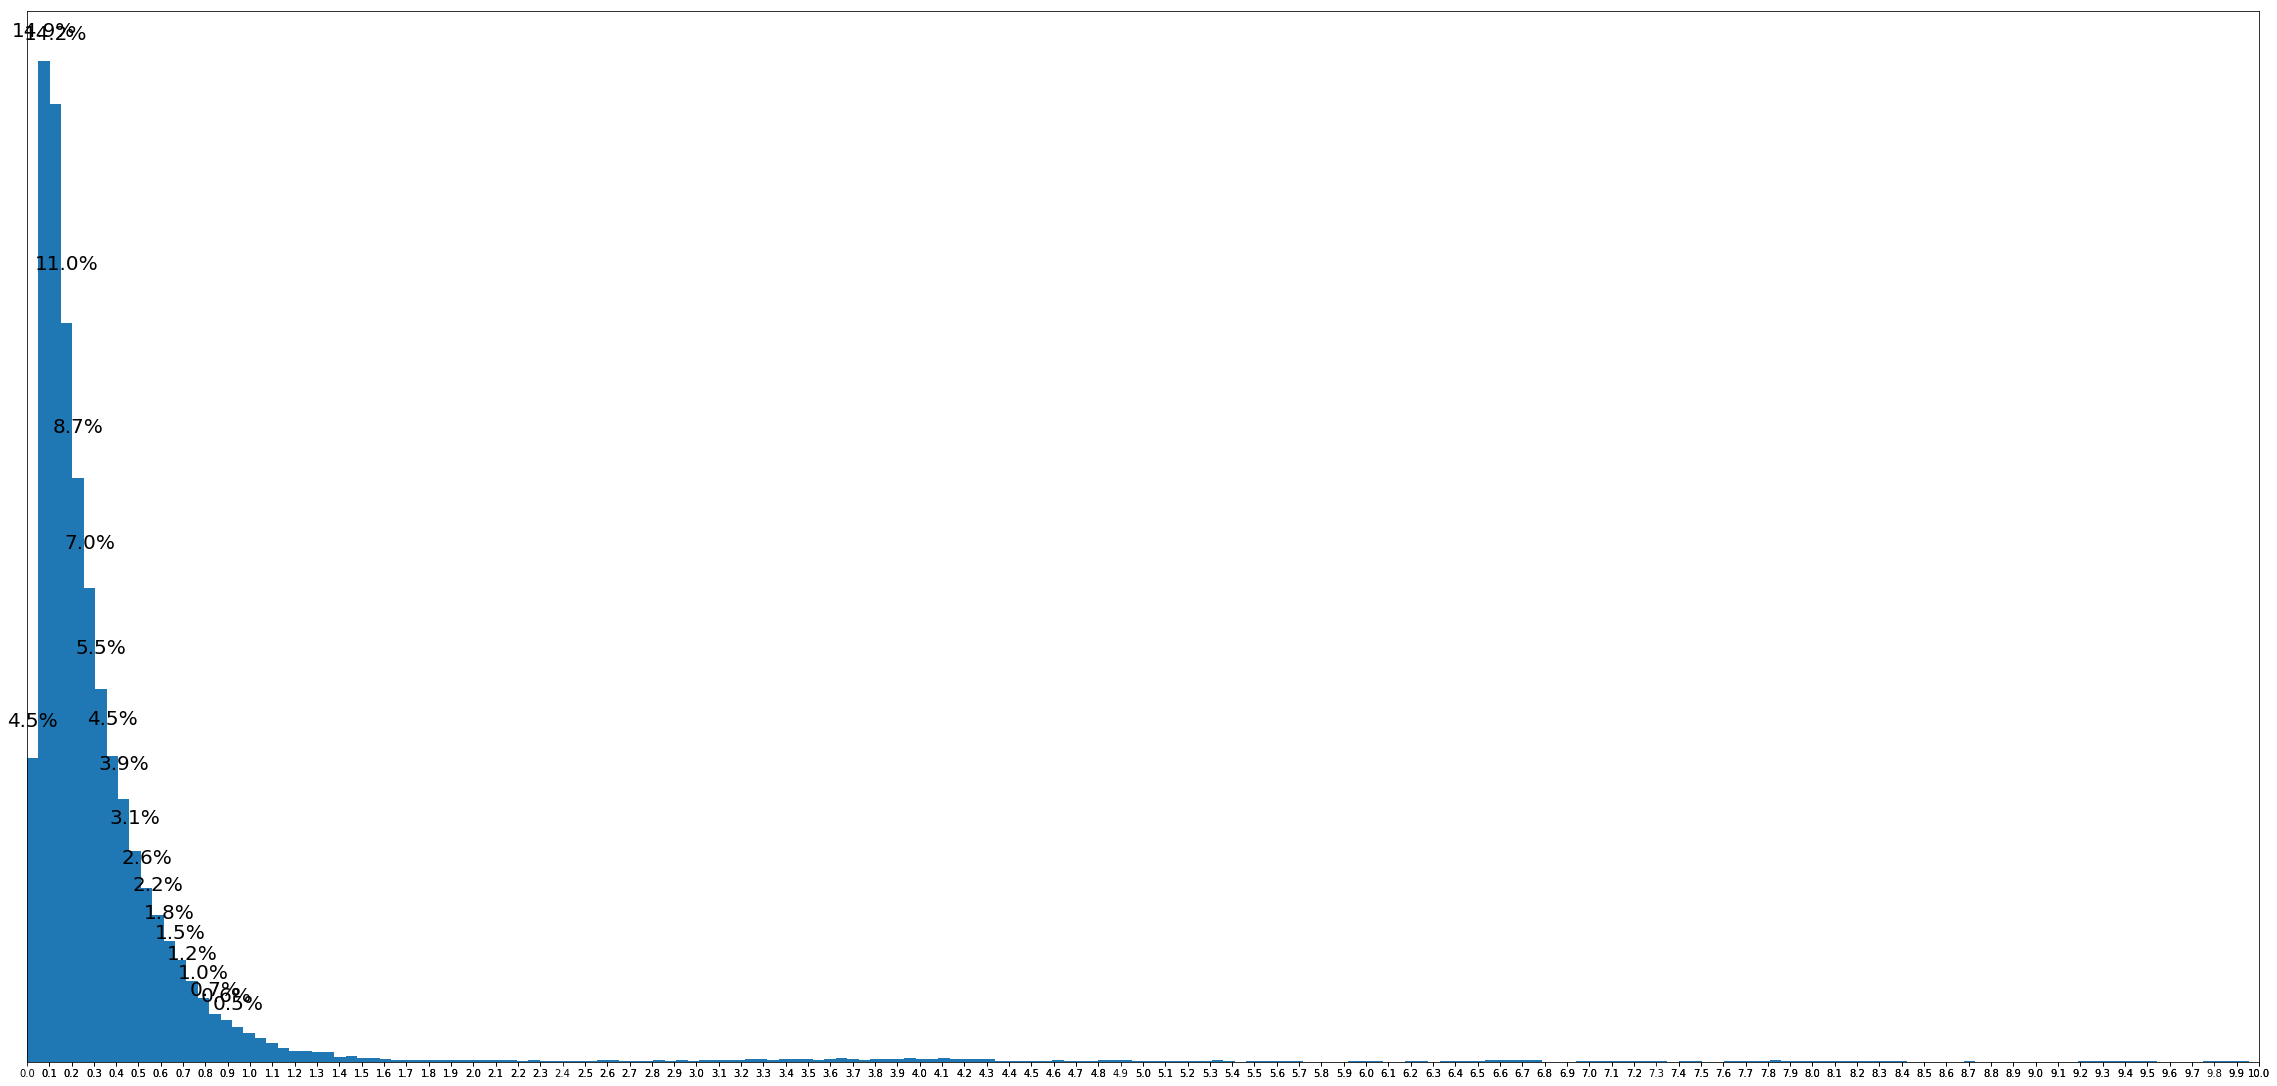

In [0]:
dist_array = eucl_distances[np.triu_indices(13092, k = 1)]
plot_distance_distribution(dist_array, bins =1000, xlim = (0,10), title = "")

## Cluster Distance Distribution

In [0]:
labels_original = np.load('/content/gdrive/My Drive/Burst_data/labels.npy')
labels_cutted = np.load('/content/gdrive/My Drive/Burst_data/labels_cutted_data.npy')
labels_cutted2 = np.load('/content/gdrive/My Drive/Burst_data/labels_cutted_data2.npy')

In [0]:
def calculate_centroids_and_distances(dataset,labels):
  centroids = {}
  distances_to_centroids = {}

  n_clusters = np.sort(np.unique(labels))
  for i in n_clusters:
    class_indices = np.where(labels == i) 
    class_i = dataset[class_indices]
    
    #class_o = np.delete(dataset_cutted2, class_indices, axis = 0)

    centroid = np.mean(class_i, axis = 0).reshape((1,dataset.shape[1]))

    distances_i = pairwise_distances(centroid,dataset, metric = "euclidean")
  

    #quantile1 = np.quantile(class_i, 0.25, axis=0)
    #quantile3 = np.quantile(class_i, 0.75, axis=0)
    #median = np.median(class_i, axis = 0)
    distances_to_centroids[i] = distances_i
    centroids[i] = centroid
   
  return centroids,distances_to_centroids

In [0]:
centroids, distances_to_centroids = calculate_centroids_and_distances(dataset_cutted2, labels_cutted2)

In [0]:
def calculate_distance_to_centroids(centroids,distances,labels):
  cluster_mean_distances = np.zeros((18,18))
  #cluster_in_and_out_distances = {}#np.zeros((18,2))
  within_cluster_distances = []
  outside_cluster_distances = []

  for i in np.sort(list(centroids.keys())):
    distances_i = distances[i][0]
    class_i_indices = np.where(labels == i)
    
    within_cluster_distances.append(distances_i[class_i_indices])
    outside_cluster_distances.append(np.delete(distances_i,class_i_indices))
    #cluster_in_and_out_distances[i] = [distances[class_i_indices],np.delete(distances_i,class_i_indices)]
    #cluster_in_and_out_distances[i,0] = np.mean(distances_i[class_i_indices])
    #cluster_in_and_out_distances[i,1] = np.mean(np.delete(distances_i,class_i_indices))
    for j in np.sort(list(centroids.keys())):
      class_j_indices = np.where(labels == j) 
      cluster_mean_distances[i,j] = np.mean(distances_i[class_j_indices]) 
 
  return cluster_mean_distances, within_cluster_distances, outside_cluster_distances

In [0]:
cluster_mean_distances, within_cluster_distances, outside_cluster_distances = calculate_distance_to_centroids(centroids, distances_to_centroids, labels_cutted2)

In [0]:
mean_within_cluster_distances = [np.mean(x) for x in within_cluster_distances]
mean_outside_cluster_distances = [np.mean(x) for x in outside_cluster_distances]

differences =  np.asarray(mean_outside_cluster_distances) - np.asarray(mean_within_cluster_distances)
differences_sorted_indices = np.argsort(differences)[::-1] 

print(differences)
print(differences_sorted_indices)

within_cluster_distances = [within_cluster_distances[i] for i in differences_sorted_indices]
outside_cluster_distances =[outside_cluster_distances[i] for i in differences_sorted_indices]

[ 0.93356134 14.86186013  2.97401608  0.657272   19.51977247  0.58342087
  3.05398047  3.49707228  2.85939842 27.48948518 37.41032473  5.96131097
  8.93869606 14.92487101  7.93149402 10.6346022  41.88910038  0.69429379]
[16 10  9  4 13  1 15 12 14 11  7  6  2  8  0 17  3  5]


In [0]:
def draw_violin_plot_of_cluster_distances(within_cluster_distances,out_cluster_distances,differences_sorted_indices,n_clusters = 18):  
  
  ticks = ['Cluster %d' % i for i in differences_sorted_indices]


  plt.figure(figsize=(25,20))

  bpl = plt.violinplot(within_cluster_distances, positions=np.array(range(len(within_cluster_distances)))*5-1, widths=2,showmeans = True, showextrema = True)

  bpr = plt.violinplot(out_cluster_distances, positions=np.array(range(len(out_cluster_distances)))*5+1, widths=2,showmeans = True, showextrema = True)


  # draw temporary red and blue lines and use them to create a legend
  plt.plot([], color = "C0", label='Distances to Centroid within Cluster')
  plt.plot([], color = "C1", label='Distances to Centroid outside Cluster')
  plt.legend()

  plt.xticks(range(0, len(ticks) * 5, 5), ticks)
  plt.xlim(-4, len(ticks)*5)
  plt.tight_layout()


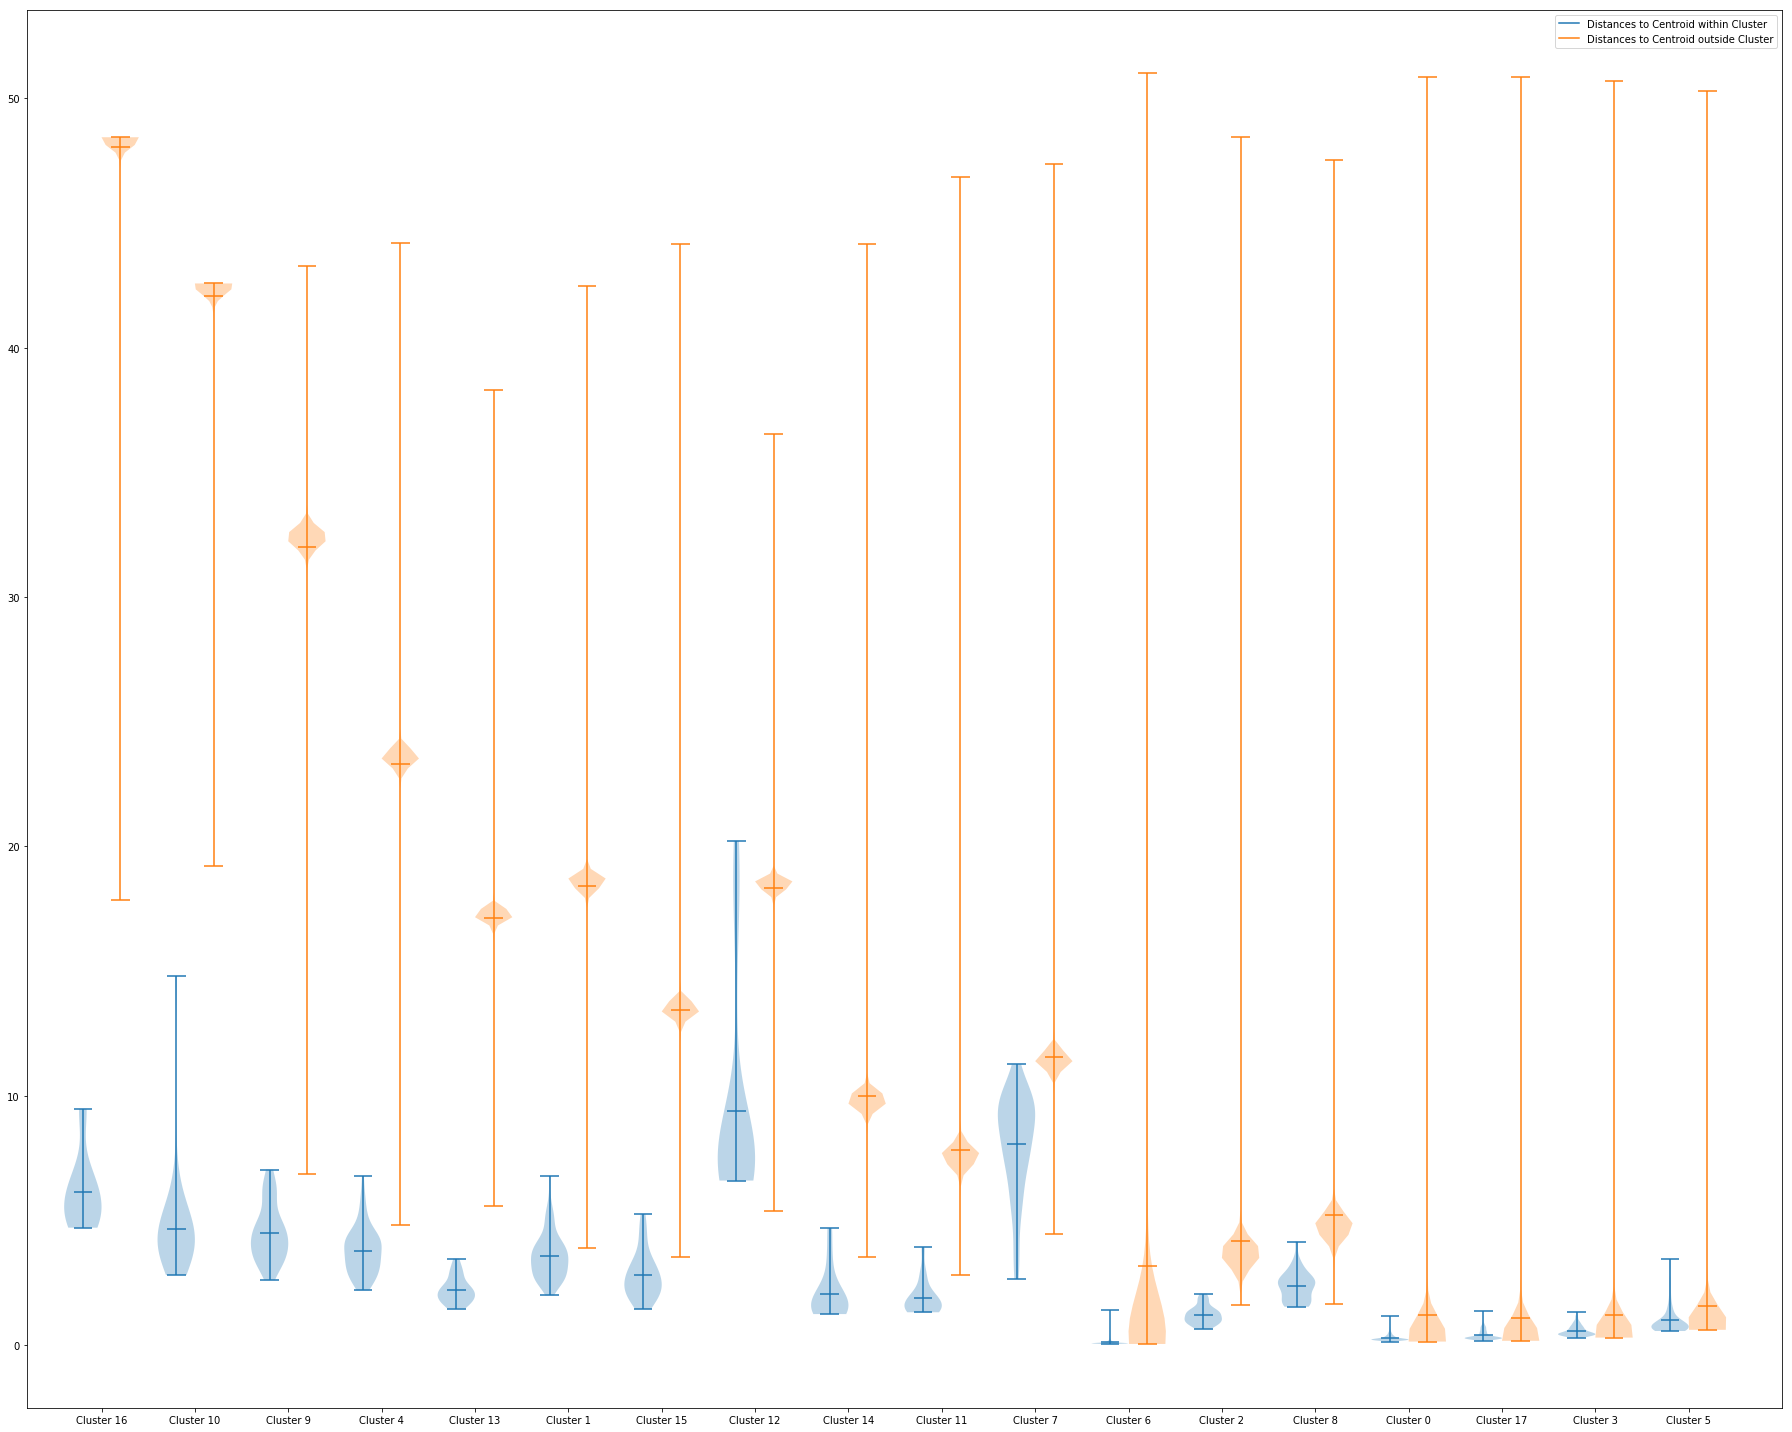

In [0]:
draw_violin_plot_of_cluster_distances(within_cluster_distances,outside_cluster_distances,differences_sorted_indices,n_clusters = 18)

In [0]:
def draw_mean_cluster_distances(cluster_mean_distances, centroids, n_clusters = 18):
  SMALL_SIZE = 15
  MEDIUM_SIZE = 20
  BIGGER_SIZE = 50

  plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
  plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
  plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
  plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
  plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize

  fig = plt.figure(figsize=(40,20))
  g= fig.add_gridspec(36, 2)
  fig.subplots_adjust(hspace=4, wspace=0.01)

  ax1 = fig.add_subplot(g[0:2*n_clusters, 0])
  sns.heatmap(cluster_mean_distances, ax = ax1)
  ax1.set_title("Cluster mean distances to Centroids", fontsize = 25)

  for i in range(n_clusters):
    ax = fig.add_subplot(g[i*2:i*2+2, 1])
    ax.set_ylim((0,10))
    ax.set_xlabel("Time")
    ax.set_title("Cluster %i Centroid" % i, fontsize = 10)
    ax.plot(centroids[i][0])

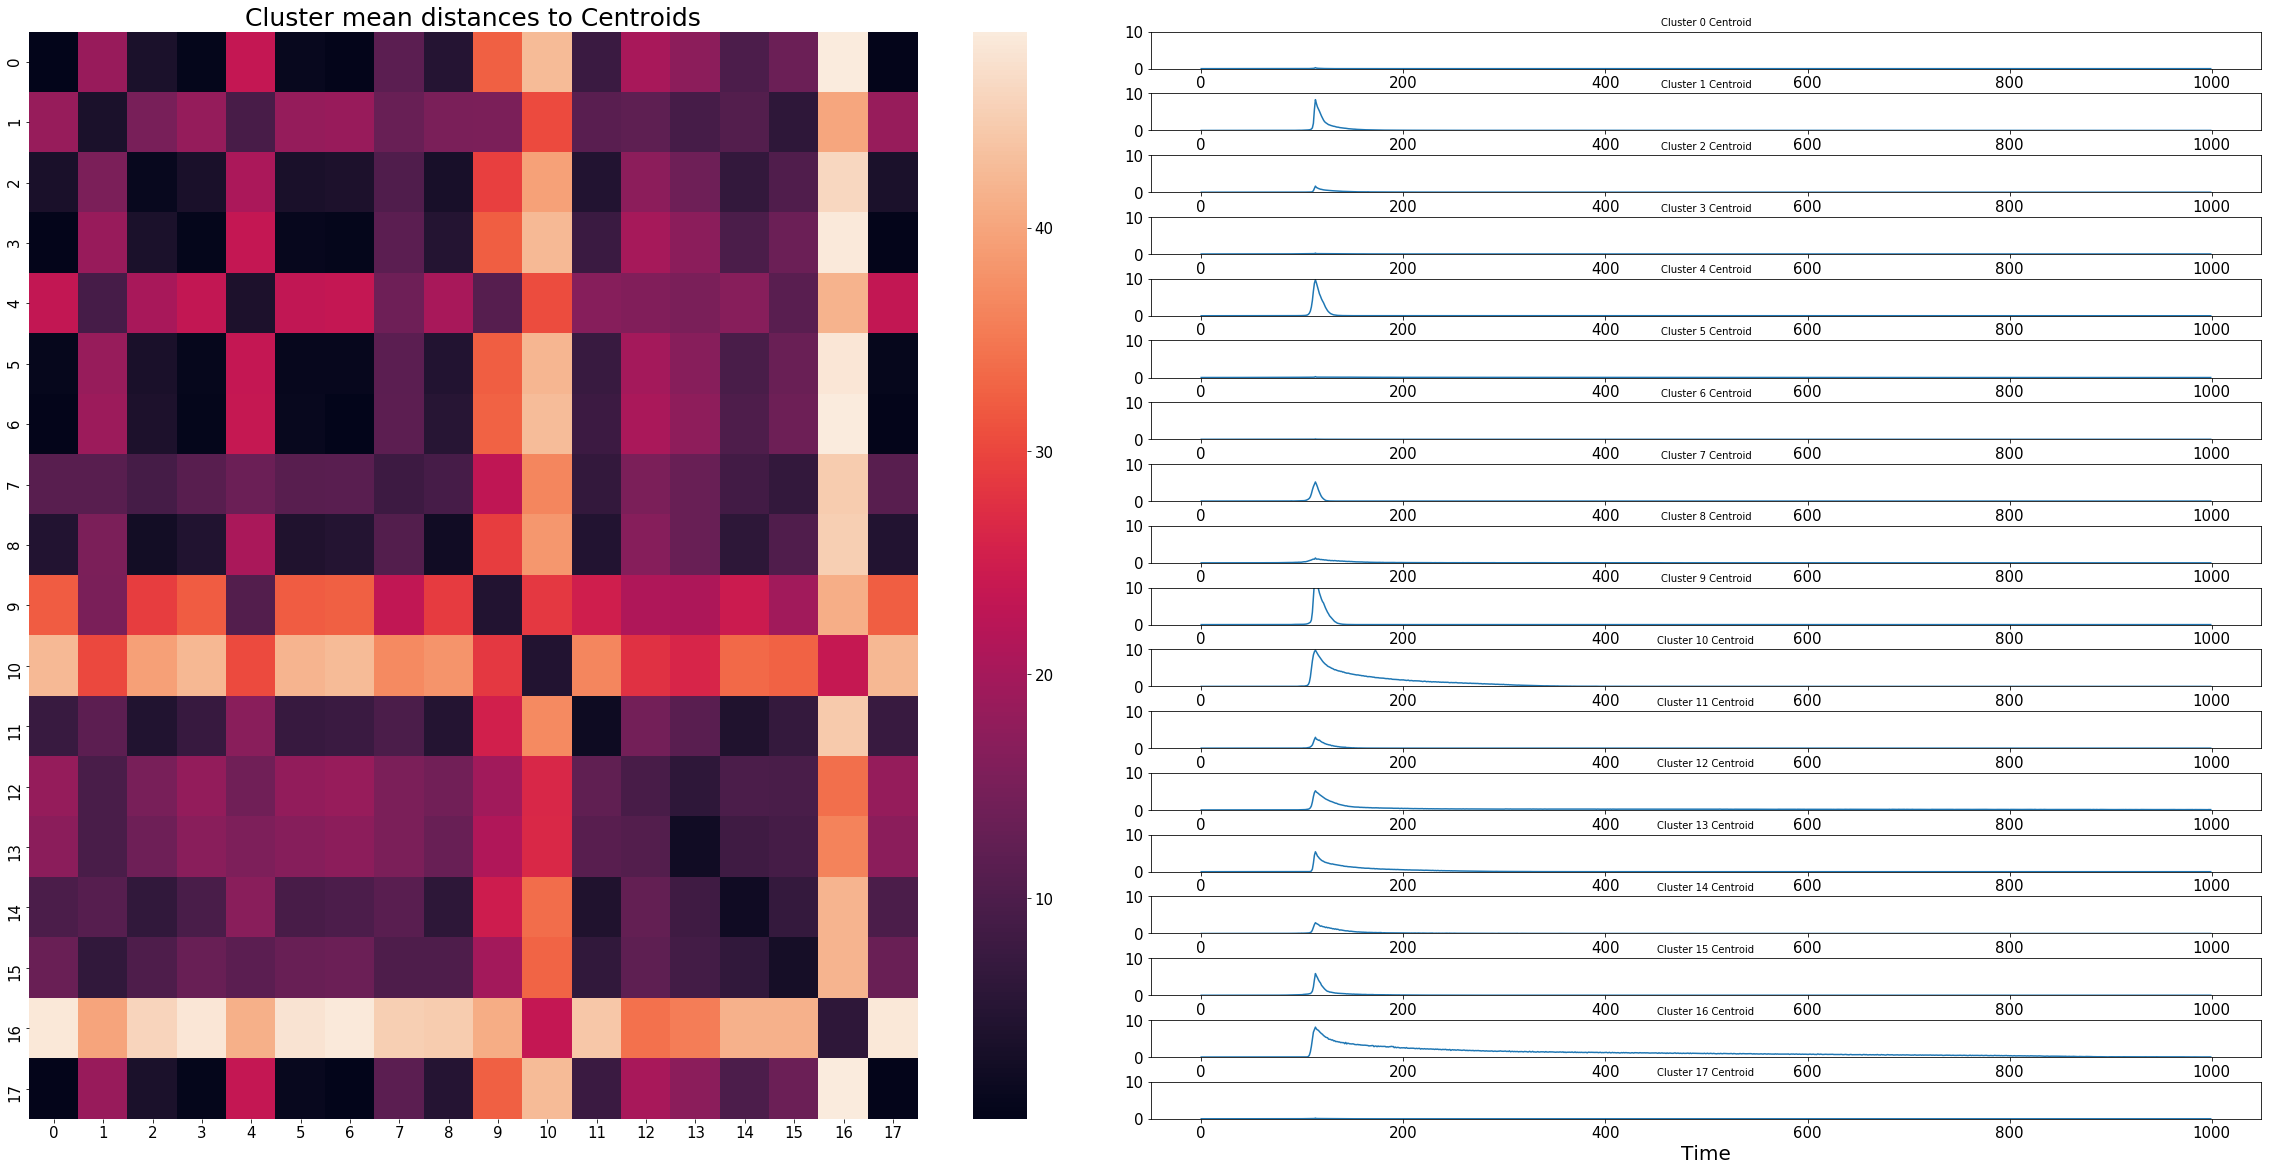

In [0]:
draw_mean_cluster_distances(cluster_mean_distances, centroids, n_clusters = 18)

In [0]:
def draw_within_cluster_distance_distribution(centroids, distances_to_centroids, labels, n_clusters = 18):
  SMALL_SIZE = 15
  MEDIUM_SIZE = 18
  BIGGER_SIZE = 50

  plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
  plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
  plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
  plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
  

  fig, axes = plt.subplots(nrows=n_clusters, ncols=2,figsize=(40,120))
  fig.subplots_adjust(hspace=0.5, wspace=0.2)
  for i in range(n_clusters):
    dist_array = distances_to_centroids[i][0]
    dist_array = dist_array[np.where(labels == i)]

    ax = axes[i,0]
    ax1 = axes[i,1]

    sns.distplot(dist_array, kde = True, bins = 50,ax=ax)
    ax.set_xlabel("Euclidean Distance")
    ax.set_title("Within Cluster %i Distance Distribution " % i,fontsize = 20)
    ax1.set_ylim((0,10))
    ax1.plot(centroids[i][0])
    ax1.set_xlabel("Time")
    ax1.set_title("Class %i Centroid" % i, fontsize = 20)

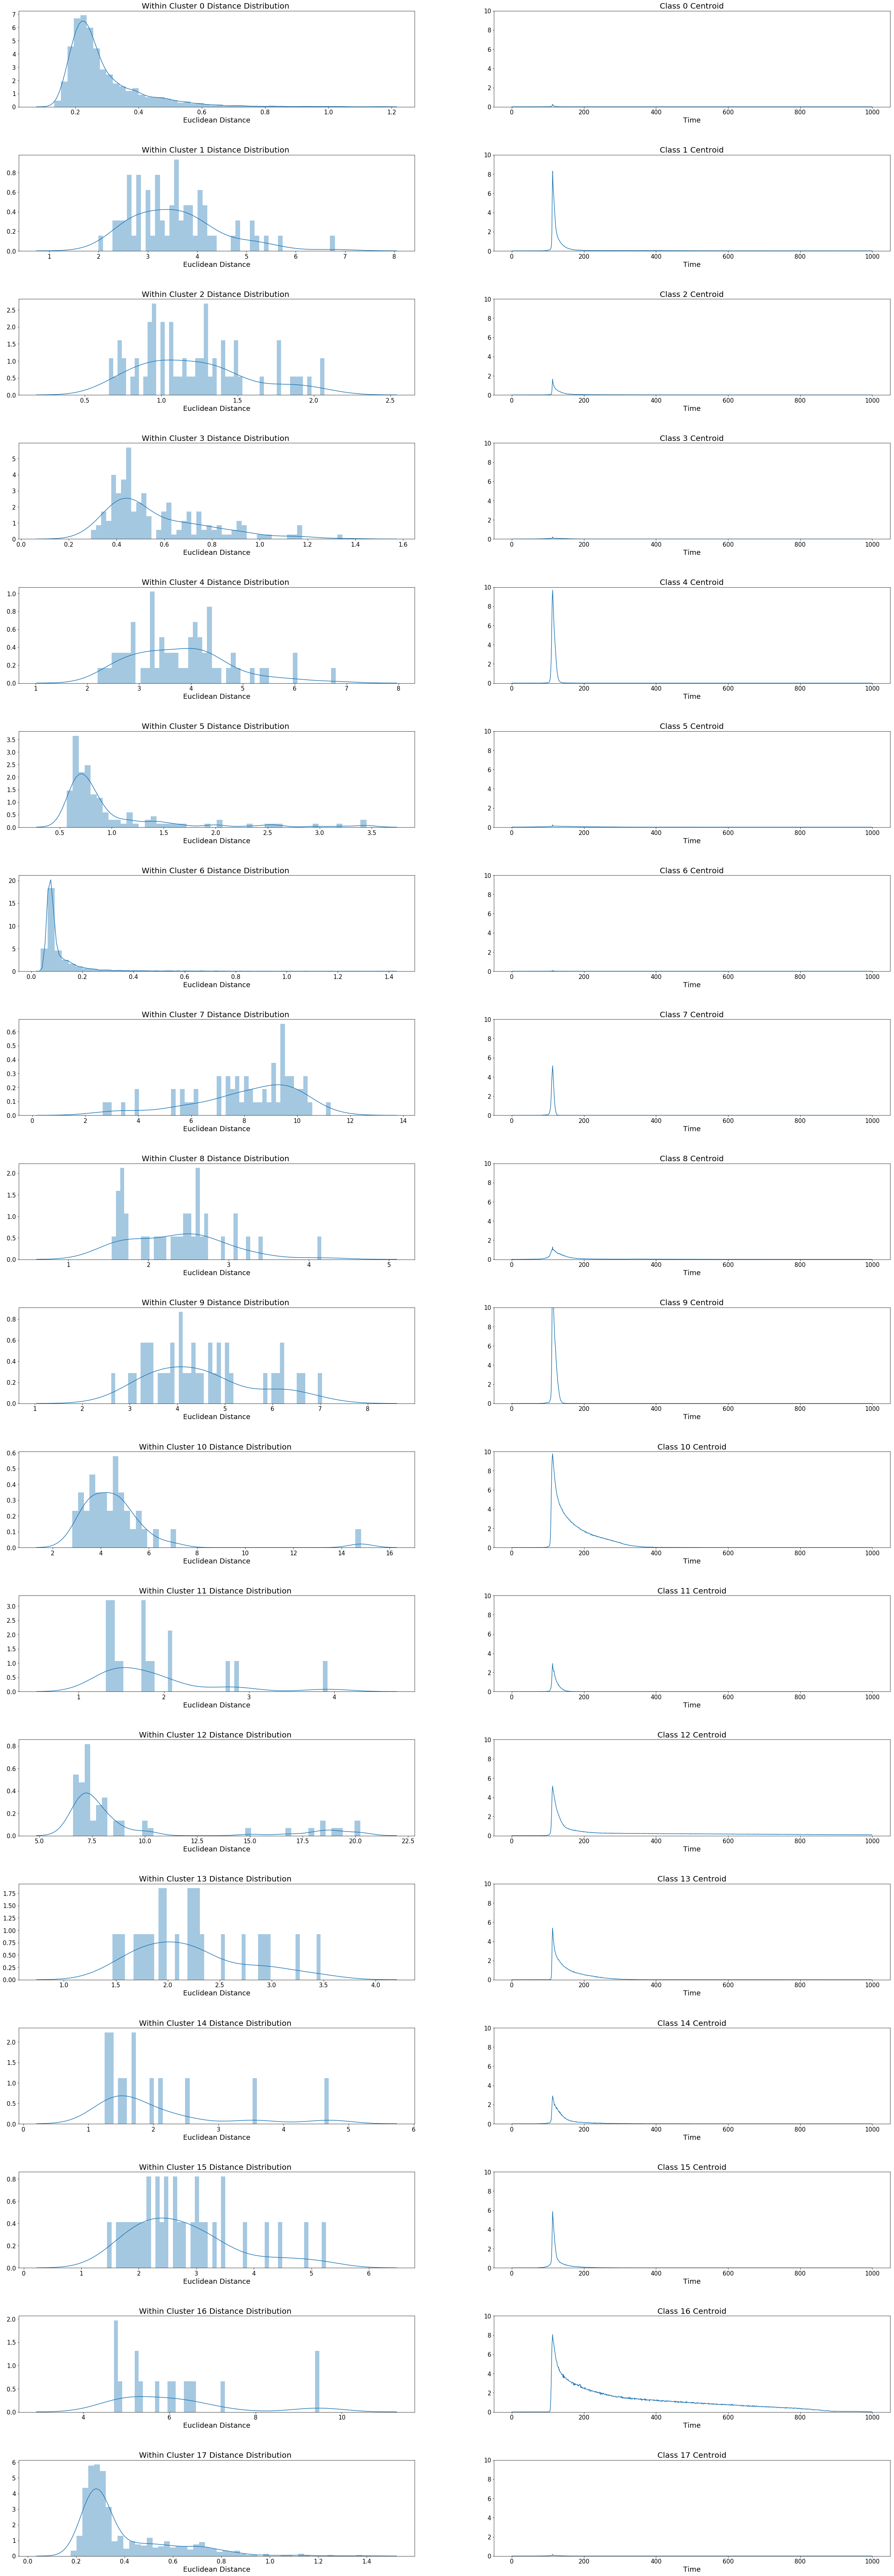

In [0]:
draw_within_cluster_distance_distribution(centroids, distances_to_centroids, labels_cutted2)

## Centroid Prediction

In [0]:
from sklearn.neighbors.nearest_centroid import NearestCentroid
clf = NearestCentroid(metric = "euclidean")
clf.fit(dataset_cutted2, labels_cutted2)
labels_predicted = clf.predict(dataset_cutted2)
centroids2 = clf.centroids_

In [0]:
def draw_prediction_differences(data,labels,labels_predicted,centroids, n_examples = 10):
  
  centroid_differences = np.where(labels_predicted != labels)[0]
  examples = np.random.choice(centroid_differences, n_examples)
  
  fig, axes = plt.subplots(nrows=n_examples, ncols=3,figsize=(40,120))
  fig.subplots_adjust(hspace=0.5, wspace=0.2)
  
  

  print("Found %d bursts with different cluster assignment!" % len(centroid_differences))

  for i,index in enumerate(centroid_differences[0:n_examples]):
    burst = data[index]

    predicted_class = labels_predicted[index]
    spectral_class = labels[index]

    ax = axes[i,0]
    ax1 = axes[i,1]
    ax2 = axes[i,2]
  
    ax.set_ylim((0,10))
    ax.plot(burst)
    ax.set_xlabel("Time")
    ax.set_title("Original Burst", fontsize = 20)
    
    ax1.set_ylim((0,10))
    ax1.plot(centroids[predicted_class][0])
    #ax1.plot(centroids2[predicted_class])
    ax1.set_xlabel("Time")
    ax1.set_title("Predicted Class %i Centroid" % predicted_class, fontsize = 20)


    ax2.set_ylim((0,10))
    ax2.plot(centroids[spectral_class][0])
    #ax2.plot(centroids2[spectral_class])
    ax2.set_xlabel("Time")
    ax2.set_title("Spectral Class %i Centroid" % spectral_class, fontsize = 20)

Found 1709 bursts with different cluster assignment!


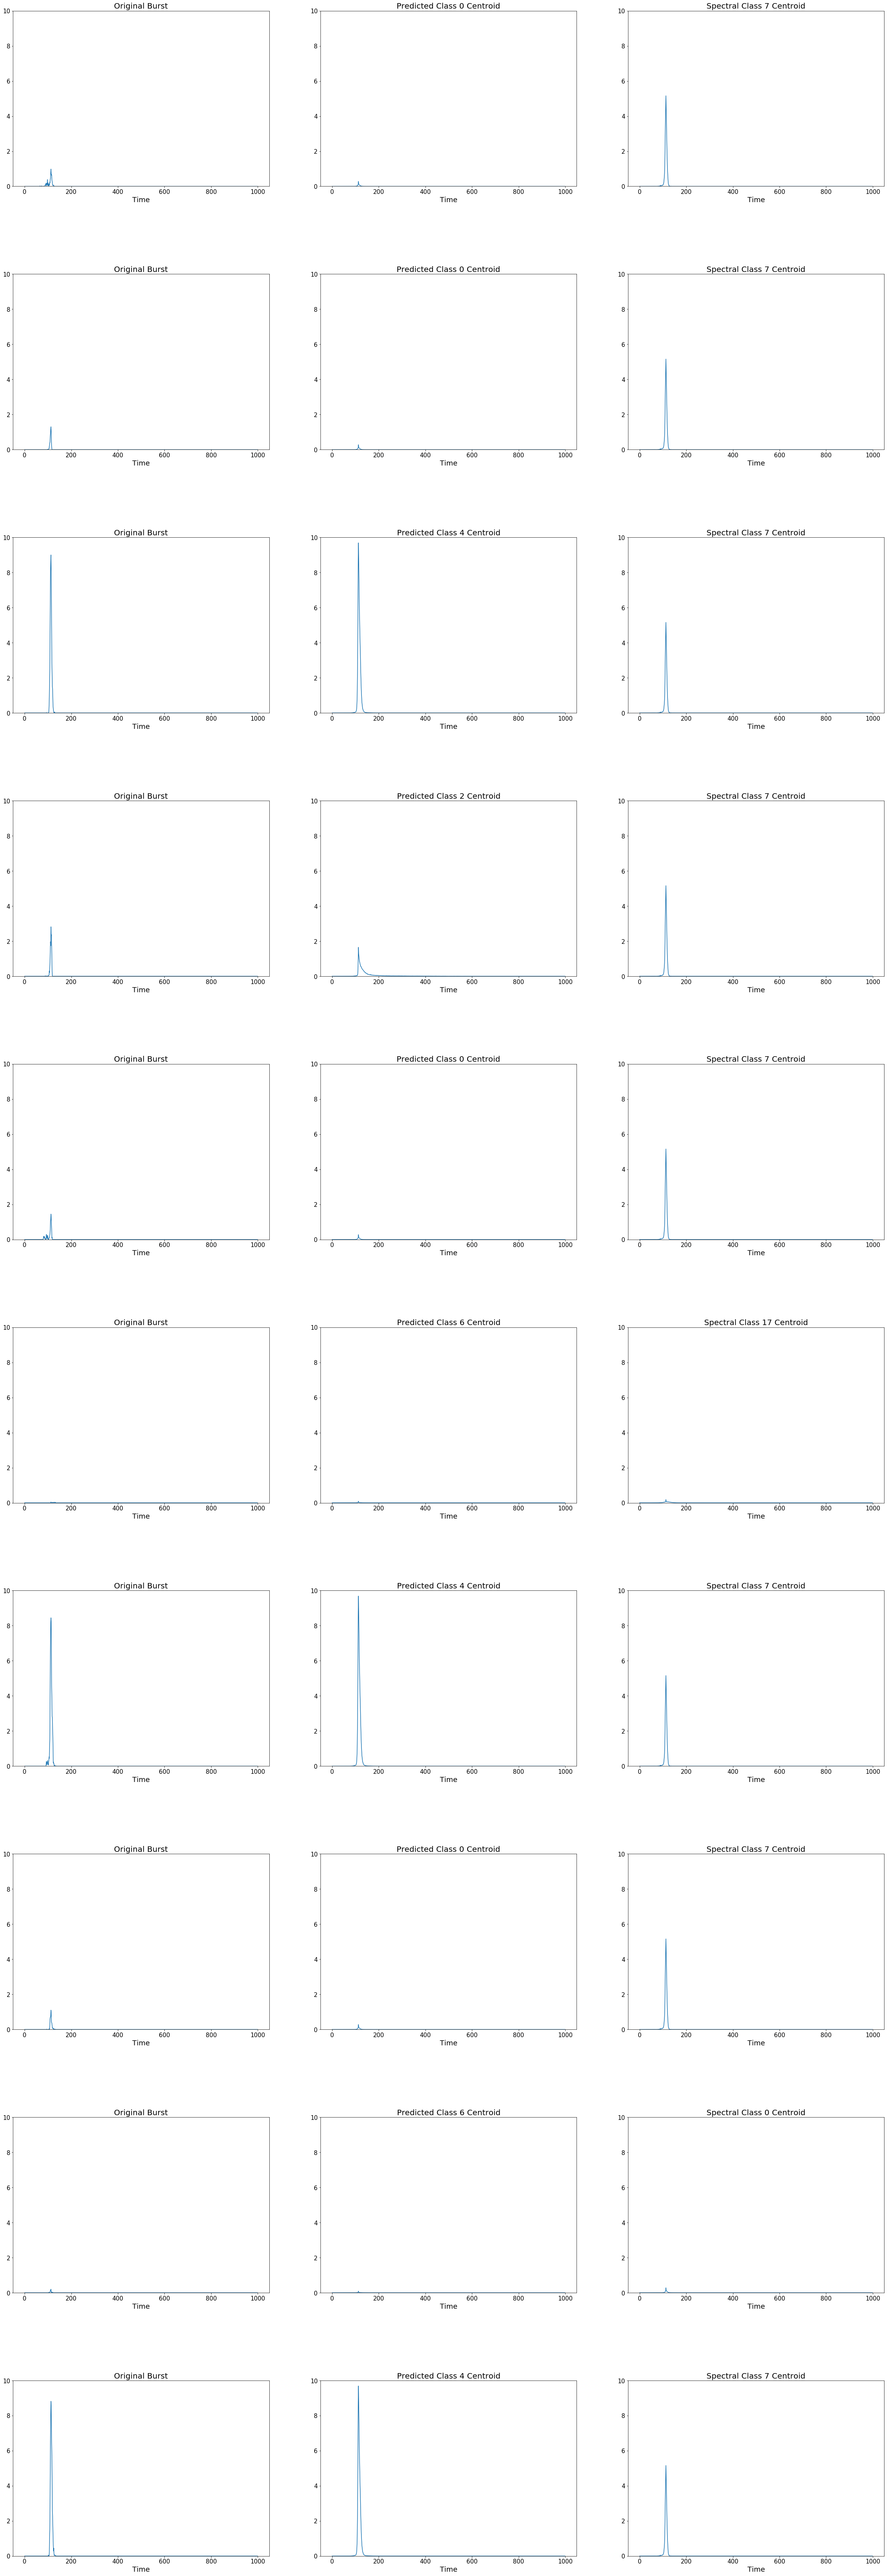

In [0]:
draw_prediction_differences(dataset_cutted2,labels_cutted2,labels_predicted,centroids, n_examples = 10)

Text(0.5, 1.0, 'Burst Examples averaged over Channels')

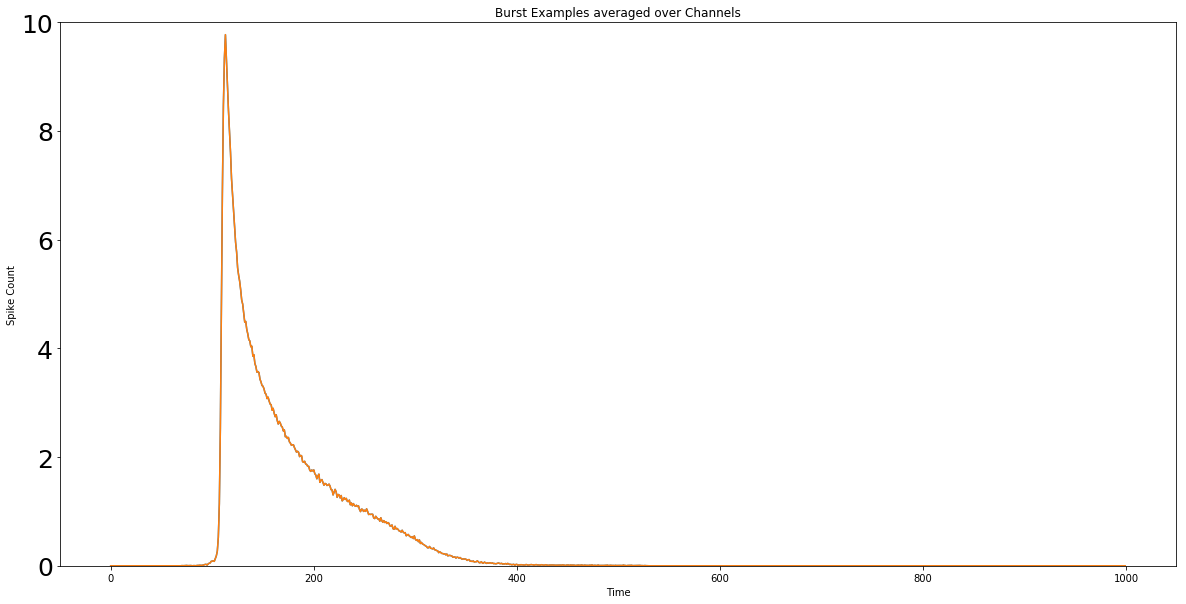

In [0]:
plt.figure(figsize=(20,10))
plt.plot(centroids[10][0])
plt.plot(centroids2[10])
plt.xlabel("Time")
plt.ylabel("Spike Count")
plt.ylim((0,10))
plt.title("Burst Examples averaged over Channels") 

# Subsampling & Graph Visualization

In [0]:
culture_counts = [141, 531, 128, 194, 1782, 2112, 1656, 554, 235, 661, 143, 142, 2853, 61, 338, 231, 30, 156, 270, 416, 77, 96, 285]
culture_names = ["C11","C12","C15","C21","C22","C23","C24","C25","C26","C31","C32", "C33", "C34","C35","C36", "C51","C52","C53","C71","C72","C81","C82","C83"]

In [0]:
print(len(culture_counts))
print(len(culture_names))

23
23


In [0]:
cultures = []
#count = 0
for i,culture in enumerate(culture_names):
  #count += len(list(np.repeat(culture, culture_counts[i])))
  #print(count)
  cultures += list(np.repeat(culture, culture_counts[i])) 

In [0]:
print(len(labels))

13092


In [0]:
print(np.sum(culture_counts))
print(len(cultures))
print(A[np.repeat([5,2,4],3),np.tile([5,2,4],3)].reshape(3,3).shape)
print(np.repeat([5,2,4],3))
print(np.tile([5,2,4],3))

13092
13092
(3, 3)
[5 5 5 2 2 2 4 4 4]
[5 2 4 5 2 4 5 2 4]


In [0]:
cutoff = 18
colors = cm.rainbow(np.linspace(0, 1, cutoff))

#fig = plt.figure(figsize=(30,25))
#fig.subplots_adjust(hspace=0.4, wspace=0.4)    
#rows = int(np.ceil(cutoff/3)) 

burst_indices = []
culture_burst_dict = {}


for i,label in enumerate(np.unique(labels)):
  class_indices = np.where(labels == label)
  #cultures_i = np.asarray(cultures)[np.where(labels == label)]
  
  samples = np.random.choice(len(class_indices[0]), min(10,len(class_indices[0])))
  burst_indices_i = class_indices[0][samples]
  bursts_i = dataset_cutted[burst_indices_i]
  cultures_i = np.asarray(cultures)[burst_indices_i]
  print(cultures_i)
  culture_burst_dict[label] = (cultures_i,bursts_i)
  burst_indices += list(burst_indices_i)
  


#row_indices = np.repeat(burst_indices, len(burst_indices))
#column_indices = np.tile(burst_indices, len(burst_indices))
#adj = A[row_indices,column_indices].reshape(len(burst_indices),len(burst_indices))
  
  #if label < cutoff:
  #  count = label + 1
  #ax = fig.add_subplot(rows, 3, count)
  #ax.set_xlabel("Time")
  #ax.set_title("Class %i " % label)
  #for burst in bursts:
  #      ax.plot(burst)

['C25' 'C25' 'C12' 'C23' 'C23' 'C24' 'C23' 'C22' 'C34' 'C12']
['C32' 'C82' 'C53' 'C82' 'C36' 'C83' 'C82' 'C83' 'C36' 'C25']
['C12' 'C12' 'C12' 'C11' 'C12' 'C12' 'C11' 'C11' 'C11' 'C12']
['C11' 'C11' 'C11' 'C11' 'C11' 'C11' 'C11' 'C11' 'C11' 'C11']
['C32' 'C26' 'C35' 'C32' 'C33' 'C35' 'C33' 'C26' 'C26' 'C26']
['C23' 'C25' 'C23' 'C25' 'C25' 'C22' 'C22' 'C23' 'C25' 'C23']
['C52' 'C52' 'C52' 'C52' 'C52' 'C52' 'C52' 'C52' 'C52' 'C52']
['C51' 'C51' 'C51' 'C51' 'C53' 'C51' 'C51' 'C51' 'C51' 'C51']
['C15' 'C15' 'C15' 'C15' 'C15' 'C15' 'C15' 'C15' 'C15' 'C15']
['C12' 'C22' 'C33' 'C72' 'C72' 'C34' 'C81' 'C71' 'C81' 'C72']
['C12' 'C72' 'C81' 'C72' 'C81' 'C53' 'C72' 'C72' 'C72' 'C81']
['C83' 'C83' 'C34' 'C31' 'C83' 'C83' 'C83' 'C34' 'C31' 'C34']
['C21' 'C21' 'C21' 'C21' 'C21' 'C21' 'C21' 'C21' 'C21' 'C21']
['C24' 'C26' 'C22' 'C22' 'C51' 'C23' 'C34' 'C34' 'C72' 'C31']
['C24' 'C24' 'C24' 'C24' 'C24' 'C25' 'C24' 'C24' 'C24' 'C25']
['C53' 'C53' 'C53' 'C53' 'C53' 'C53' 'C53' 'C53' 'C53' 'C53']
['C34' '

In [0]:
row_indices = np.repeat(burst_indices, len(burst_indices))
column_indices = np.tile(burst_indices, len(burst_indices))
A_sampled = eucl_distances[row_indices,column_indices].reshape(len(burst_indices),len(burst_indices))
A_sampled_sorted_indices = np.argsort(A_sampled, axis = 1)
print(A_sampled.shape)

(180, 180)


In [0]:
A_sampled_graph = construct_knn_graph(A_sampled,A_sampled_sorted_indices, k=20, mutual=False,weighted="distance")
print(A_sampled_graph.shape)

(180, 180)


In [0]:
A_sampled_graph = A_sampled_graph + 0.1/n * np.ones(A_sampled_graph.shape)

In [0]:
G = nx.from_numpy_matrix(A_sampled_graph)

In [0]:
print(G.nodes)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179]


In [0]:
node_cultures = []
node_labels = []
node_bursts = []

for i,label in enumerate(np.unique(labels)):
  cultures_i = list(culture_burst_dict[label][0])
  bursts_i = list(culture_burst_dict[label][1])
  print(len(bursts_i))
  node_bursts += bursts_i
  node_cultures += cultures_i
  node_labels += list(np.repeat("Cluster %d" % label, len(cultures_i)))

10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10


In [0]:
print(len(node_bursts))

180


In [0]:
SMALL_SIZE = 15
MEDIUM_SIZE = 20
BIGGER_SIZE = 50

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)


for i, burst in enumerate(node_bursts):
    plt.figure(figsize=(20,10))
    plt.plot(burst)
    plt.xlabel("Time")
    plt.ylabel("Spike Count")
    plt.ylim((0,10))
    plt.title("Burst Examples averaged over Channels") 
    plt.savefig('/content/gdrive/My Drive/Burst_data/Burst_Examples_Plots/burst%d.png' % i)
    
    plt.close()

{0: Text(0.2772365152622943, 0.052936542894705445, 'C34'),
 1: Text(0.2639272117482027, 0.051629362966446726, 'C34'),
 2: Text(0.27374275120099356, 0.054008587220501524, 'C23'),
 3: Text(0.2732568201653589, 0.05201925240616375, 'C34'),
 4: Text(0.26197982136745995, 0.05454499309153599, 'C24'),
 5: Text(0.2688163470169841, 0.052168962704214616, 'C22'),
 6: Text(0.2677160964468466, 0.046559642879422845, 'C22'),
 7: Text(0.2574206229948457, 0.058874504606951726, 'C23'),
 8: Text(0.26498252931814276, 0.04852382810231691, 'C34'),
 9: Text(0.26755173656812165, 0.05106405691789834, 'C51'),
 10: Text(0.2653265405681207, 0.1302487936774524, 'C82'),
 11: Text(0.28246083869601035, 0.04571027224040492, 'C32'),
 12: Text(0.2754031497972532, 0.03792742072180887, 'C22'),
 13: Text(0.23420294995168867, 0.04579702905902743, 'C34'),
 14: Text(0.27626855036780823, 0.10785083141590436, 'C34'),
 15: Text(0.2832443464261496, 0.03179007299380792, 'C23'),
 16: Text(0.28835756142091845, 0.04749347121749922, 'C

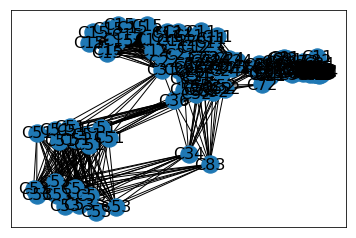

In [0]:
pos=nx.kamada_kawai_layout(G)
l = dict(zip(G.nodes, node_cultures))
nx.draw_networkx_nodes(G, pos)
nx.draw_networkx_edges(G, pos)
nx.draw_networkx_labels(G, pos, l, font_size=16)

In [0]:
print(A[0,:])
print(np.amax(A[0,:]))
print(np.amax(A_sampled_graph[0,:]))

[7.63825237e-06 7.63825237e-06 7.63825237e-06 ... 7.63825237e-06
 7.63825237e-06 7.63825237e-06]
7.851900545203037
1.0380269746013349


In [0]:
with open("/content/gdrive/My Drive/Burst_data/color_map.txt") as f:
    color_map = f.read().splitlines()
color_map = np.reshape(color_map,(16,16))

chosen_colors = list(color_map[:-2,7]) + list(color_map[5:9,15])
np.random.seed(17)
np.random.shuffle(colors)

FileNotFoundError: ignored

In [0]:
import matplotlib.colors
own_cmap = matplotlib.colors.ListedColormap(chosen_colors)

In [0]:
! ls -l

total 2932
drwx------ 3 root root    4096 Oct 14 08:01 gdrive
-rw-r--r-- 1 root root 2992140 Oct 14 12:46 graph.html.html
drwxr-xr-x 1 root root    4096 Aug 27 16:17 sample_data


In [0]:
image_files = os.listdir('/content/gdrive/My Drive/Burst_data/Burst_Examples_Plots/')
image_files = np.core.defchararray.add(np.repeat('/content/gdrive/My Drive/Burst_data/Burst_Examples_Plots/', len(image_files)), np.asarray(image_files).astype("str"))

#image_files = np.repeat('https://bokeh.pydata.org/static/snake4_TheRevenge.png', len(image_files))  
#image_files = np.repeat('https://upload.wikimedia.org/wikipedia/commons/1/1b/Simulation_of_hrose_neuron.png', len(image_files))
#print(image_files[0:10])

In [0]:
from io import BytesIO
from PIL import Image
import base64


def embeddable_image(infile):
    #img_data = 255 - 15 * data.astype(np.uint8)
    #print(img_data.shape)
    image = Image.open(infile)
    buffer = BytesIO()
    image.save(buffer, format='png')
    
    for_encoding = buffer.getvalue()
    return 'data:image/png;base64,' + base64.b64encode(for_encoding).decode()
  
  
img = list(map(embeddable_image, image_files))

In [0]:
from bokeh.models import HoverTool


class StickyHoverTool(HoverTool):
    __implementation__ = "/content/gdrive/My Drive/Burst_data/sticky_hover_tool.ts"

In [0]:
! ls -l gdrive/MyDrive/

ls: cannot access 'gdrive/MyDrive/': No such file or directory


In [0]:
from bokeh.models import HoverTool
from bokeh.models import TapTool
from bokeh.models import CustomJS, HoverTool, Div, Row
from bokeh.events import Tap
from bokeh.io import output_notebook 
output_notebook()


TOOLTIPS = """
    <div>
        <div>
            <img
                src="@img" height="400" alt="@img" width="600"
                style="float: left; margin: 0px 0px 0px 0px;"
                border="2"
            ></img>
        </div>
   
    </div>
"""
#sticky_hover = StickyHoverTool(tooltips=TOOLTIPS)
hover = HoverTool(tooltips=TOOLTIPS)





'''The essential functionality'''
nxg = G
hv.extension('bokeh')
kwargs = dict(width=1000, height=1000, xaxis=None, yaxis=None)
hv.opts.defaults(hv.opts.Nodes(**kwargs), hv.opts.Graph(**kwargs), )

# choose a NetworkX graphical layout 


#pos = nx.spring_layout(nxg,k=0.15,iterations=20)  
#pos = nx.layout.fruchterman_reingold_layout(nxg, scale = 4, k = 1/np.sqrt(354))
pos = nx.layout.kamada_kawai_layout(nxg, scale = 6)
#pos = nx.layout.spectral_layout(nxg)
nx.set_node_attributes(nxg, dict(zip(G.nodes, node_cultures)), 'culture')
nx.set_node_attributes(nxg, dict(zip(G.nodes, node_labels)), 'cluster')
nx.set_node_attributes(nxg, dict(zip(G.nodes, img)), 'img')



# collect graph from NetworkX 
my_graph = hv.Graph.from_networkx(nxg, pos).options(color_index='cluster', cmap = own_cmap, tools = [hover,"tap"], node_size=50)
c = hv.Labels(my_graph.nodes, ['x', 'y'], 'culture')



# bundle edges 
bundled = bundle_graph(my_graph)
bundled.opts(padding=0.01) 


graph_plot = hv.renderer('bokeh').get_plot(bundled*c)
print(type(bundled))


from bokeh.plotting import figure, show
from bokeh.io import output_notebook
hv.extension('bokeh')
output_notebook()
#show(bundled)
bundled*c


#renderer = hv.renderer('bokeh')
#renderer.save(bundled, 'graph.html')

#display_html(renderer.static_html(bundled*c), raw=True)



Output hidden; open in https://colab.research.google.com to view.

In [0]:
from bokeh.plotting import figure, output_file, show, ColumnDataSource
nodes = my_graph.nodes


source = ColumnDataSource(data = dict(
x = nodes["x"],
y = nodes["y"],
labels = nodes["cluster"],
imgs = nodes["img"]))

div = Div(text = '<div id="tooltip" style="position: absolute; display: none"></div>', name = 'tooltip')

code = '''  if (cb_data.source.selected.indices.length > 0){
                var selected_index = cb_data.source.selected.indices[0];
                var tooltip = document.getElementById("tooltip");

                tooltip.style.display = 'block';
                tooltip.style.left = Number(cb_data.geometries.sx) + Number(20) + 'px';
                tooltip.style.top = Number(cb_data.geometries.sy) - Number(20) + 'px';

                tp = tp.replace('@imgs', cb_data.source.data.imgs[selected_index]);
                tp = tp.replace('$index', selected_index);
                tp = tp.replace('$x', Math.round(cb_data.geometries.x));
                tp = tp.replace('$y', Math.round(cb_data.geometries.y));
                tooltip.innerHTML = tp;
          } '''

tap = TapTool(callback = CustomJS(args = {'tp': TOOLTIPS}, code = code) )

#source.selected.js_on_change('indices', CustomJS(code = 'if (cb_obj.indices.length == 0) document.getElementById("tooltip").style.display = \"none\"'))
my_graph = hv.Graph.from_networkx(nxg, pos).options(color_index='cluster', cmap = own_cmap, tools = [hover,tap], node_size=50)

c = hv.Labels(my_graph.nodes, ['x', 'y'], 'culture')



# bundle edges 
bundled = bundle_graph(my_graph)
bundled.opts(padding=0.01) 


graph_plot = hv.renderer('bokeh').get_plot(bundled*c)
print(type(bundled))


from bokeh.plotting import figure, show
from bokeh.io import output_notebook
hv.extension('bokeh')
output_notebook()
#show(bundled)
bundled*c



Output hidden; open in https://colab.research.google.com to view.